![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [73]:
# Run the cells below first

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [75]:
# Start coding here
# Use as many cells as you need

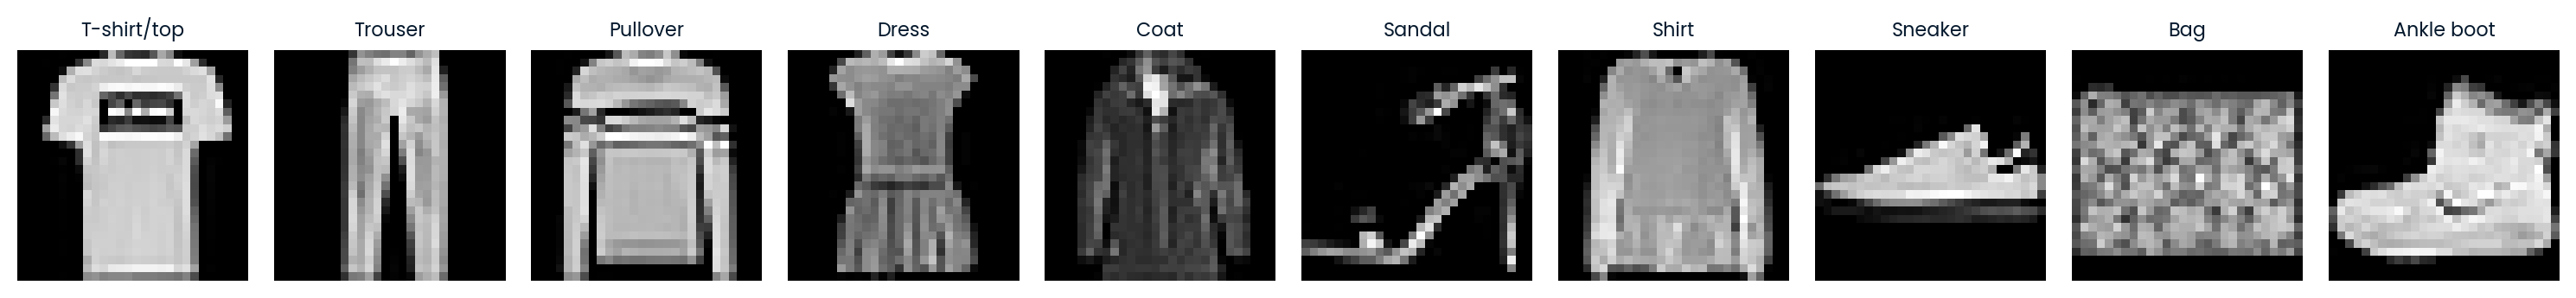

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load the dataset
fashion_mnist = datasets.FashionMNIST(
    root='.', 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)

# Class labels in FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Store one example per class
seen_labels = {}
for image, label in fashion_mnist:
    if label not in seen_labels:
        seen_labels[label] = image
    if len(seen_labels) == 10:
        break

# Plot one example of each class
plt.figure(figsize=(15, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(seen_labels[i].squeeze(), cmap='gray')
    plt.title(class_names[i], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Dataset size
dataset_size = len(fashion_mnist)

# One sample to inspect shape
sample_image, sample_label = fashion_mnist[0]

# Number of classes
num_classes = len(set(fashion_mnist.targets.numpy()))

# Print information
print(f"Total images in dataset: {dataset_size}")
print(f"Image shape: {sample_image.shape}")  # should be [1, 28, 28]
print(f"Number of classes: {num_classes}")

Total images in dataset: 60000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [9]:
# Get the number of classes to train for

classes = fashion_mnist.classes
print(classes)
num_classes = len(fashion_mnist.classes)
print(num_classes)


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [10]:
num_input_channels = 1
num_output_channels = 20
image_size = fashion_mnist[0][0].shape[1]
print(image_size)

28


In [11]:
# Neural Network Architecture
class MultiClassImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()
        # Convolution Layer
        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        # ReLU Layer (does not change output size)
        self.relu = nn.ReLU()
        # MaxPooling Layer (output size decreases to 1/2 in both dimensions)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flattening (output flattens out into vector)
        self.flatten = nn.Flatten()

        # Fully connected layer
        self.linear = nn.Linear(num_output_channels * (image_size//2)**2, num_classes)
        
    def forward(self, x):
        # Forward pass of input through each layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [15]:
dataloader_train = DataLoader(fashion_mnist, batch_size=int(len(fashion_mnist)/1000), shuffle=True)

In [16]:
#  Training Parameters
def train_model(optimizer, net, num_epochs):

    num_processed = 0
    criterion = nn.CrossEntropyLoss()

    losses_list = []
    # Begin training loop (backward pass)
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0

        for features, labels in dataloader_train:
            optimizer.zero_grad() # Set all gradients to zero
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)
        print(f'Epoch Number {epoch}: Loss encountered {running_loss / num_processed}')
        losses_list.append(running_loss / num_processed)
        
    train_loss = running_loss / len(dataloader_train)
    
    plt.plot(losses_list)
    plt.show()
    
    return train_loss

In [17]:
# Initiate object of neural net
net = MultiClassImageClassifier(num_classes)
net.train()

# Initiate optimizer
optimizer = optim.Adam(net.parameters(), lr=0.01)

Epoch Number 0: Loss encountered 0.006624446061998606
Epoch Number 1: Loss encountered 0.004845642272010445
Epoch Number 2: Loss encountered 0.004417125223701199
Epoch Number 3: Loss encountered 0.004032821426105996


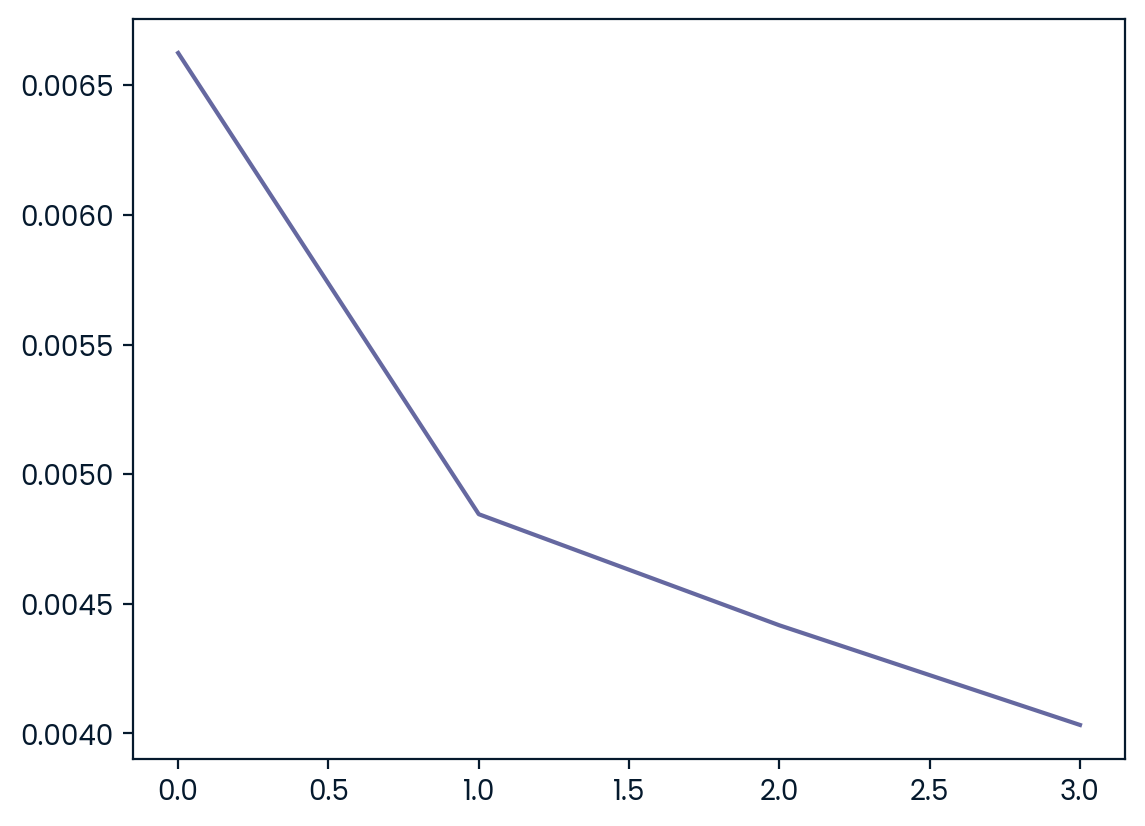

0.24196928556635977

In [18]:
# Model Training 6 epcohs
train_model(optimizer=optimizer, net=net, num_epochs=4)

In [19]:
# Making dataloader for my test_data
dataloader_test = DataLoader(fashion_mnist, batch_size=int(len(fashion_mnist)/1000), shuffle=True)
                             
# Defining the scores to use
acc = Accuracy(task='multiclass', num_classes=num_classes)
prec = Precision(task='multiclass', num_classes=num_classes, average=None)
recall = Recall(task='multiclass', num_classes=num_classes, average=None)

In [21]:
# Testing the model performance
net.eval() 

predictions = []
for i, (features, labels) in enumerate(dataloader_test):
    output = net.forward(features.reshape(-1, 1, image_size, image_size)) # Running forward pass
    pred = torch.argmax(output, dim=-1)
    predictions.extend(pred.tolist())
    # Getting scores
    acc(pred, labels)
    prec(pred, labels)
    recall(pred, labels)

In [22]:
# Evaluation Metrics Calculation
accuracy = acc.compute().item()
precision = prec.compute().tolist()
recal = recall.compute().tolist()
print('Model Accuracy:', accuracy)
print('Model Precision (per class):', precision)
print('Model Precision (average):', sum(precision)/(num_classes))
print('Model Recall (per class):', recal)
print('Model Recall (average):', sum(recal)/num_classes)

Model Accuracy: 0.9244666695594788
Model Precision (per class): [0.8771814107894897, 0.9951553344726562, 0.8939580917358398, 0.9574655890464783, 0.7960901856422424, 0.9866160154342651, 0.8126236200332642, 0.9819143414497375, 0.9908592104911804, 0.9670383930206299]
Model Precision (average): 0.9258902192115783
Model Recall (per class): [0.8880000114440918, 0.9928333163261414, 0.8458333611488342, 0.9041666388511658, 0.9298333525657654, 0.9951666593551636, 0.753166675567627, 0.9591666460037231, 0.9936666488647461, 0.9828333258628845]
Model Recall (average): 0.9244666635990143
